In [2]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent 
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

%load_ext autoreload
%autoreload 2

Added to path: /Users/elshaday/DEV/10Academy/credit-risk-probability-week4


### Recency, Frequency, and Monetary (RFM) for each customer

In [3]:
from src import DataManager
import pandas as pd
from scripts.constants import Columns, PROCESSED_FEATURES_DATA_FILE_NAME
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

In [4]:
dm = DataManager()
raw_df = dm.load_csv()


Loading ../data/raw/raw_data.csv...
Sucessfully loaded ../data/raw/raw_data.csv!


In [6]:
# Step 1: Recency: Number of days between a fixed snapshot date (one day after the last transaction) and customer’s most recent transaction
# Interpretation: Lower Recency = more recent activity = lower risk and Higher Recency = long inactivity = higher risk


# Parse date column
raw_df[Columns.TransactionStartTime.value] = pd.to_datetime(
    raw_df[Columns.TransactionStartTime.value], errors="coerce", utc=True
)
raw_df[Columns.TransactionStartTime.value].dtype

# Snapshot Date
last_transaction_time = raw_df[Columns.TransactionStartTime.value].max()
snapshot_date = last_transaction_time + pd.Timedelta(days=1)

# Most recent transaction
print("Take most recent transaction time for each customer:")
grouped_customer_df = (
    raw_df.groupby(Columns.CustomerId.value)
    .agg(
        MostRecentTransactionStartTime=(
            Columns.TransactionStartTime.value,
            "max",
        ),
        Frequency=(Columns.TransactionId.value, "count"),
        Monetary=(Columns.Amount.value, "sum"),
    )
    .reset_index()
)

grouped_customer_df["Recency"] = (
    snapshot_date - grouped_customer_df["MostRecentTransactionStartTime"]
).dt.days


# Remove MostRecentTransactionStartTime
grouped_customer_df.drop(columns=["MostRecentTransactionStartTime"], inplace=True)


print(tabulate(grouped_customer_df.head(), headers="keys", tablefmt="grid"))
print(
    f"\nSnapshot Date (One Day After Most Recent Transaction in DataSet): {snapshot_date}"
)


Take most recent transaction time for each customer:
+----+-----------------+-------------+------------+-----------+
|    | CustomerId      |   Frequency |   Monetary |   Recency |
+====+=================+=============+============+===========+
|  0 | CustomerId_1    |           1 |     -10000 |        84 |
+----+-----------------+-------------+------------+-----------+
|  1 | CustomerId_10   |           1 |     -10000 |        84 |
+----+-----------------+-------------+------------+-----------+
|  2 | CustomerId_1001 |           5 |      20000 |        90 |
+----+-----------------+-------------+------------+-----------+
|  3 | CustomerId_1002 |          11 |       4225 |        26 |
+----+-----------------+-------------+------------+-----------+
|  4 | CustomerId_1003 |           6 |      20000 |        12 |
+----+-----------------+-------------+------------+-----------+

Snapshot Date (One Day After Most Recent Transaction in DataSet): 2019-02-14 10:01:28+00:00


In [7]:
print("Data understanding:")
print(tabulate(grouped_customer_df.describe(), headers="keys", tablefmt="grid"))


print("\nScale RFM values before clustering:")
scaler = RobustScaler()
for col in grouped_customer_df.columns:
    if not col==Columns.CustomerId.value:
        grouped_customer_df[col] = scaler.fit_transform(grouped_customer_df[[col]])

print(tabulate(grouped_customer_df.head(), headers="keys", tablefmt="grid"))

Data understanding:
+-------+-------------+------------------+-----------+
|       |   Frequency |         Monetary |   Recency |
+=======+=============+==================+===========+
| count |   3742      |   3742           | 3742      |
+-------+-------------+------------------+-----------+
| mean  |     25.5644 | 171738           |   31.4613 |
+-------+-------------+------------------+-----------+
| std   |     96.9296 |      2.7173e+06  |   27.1189 |
+-------+-------------+------------------+-----------+
| min   |      1      |     -1.049e+08   |    1      |
+-------+-------------+------------------+-----------+
| 25%   |      2      |   4077.44        |    6      |
+-------+-------------+------------------+-----------+
| 50%   |      7      |  20000           |   25      |
+-------+-------------+------------------+-----------+
| 75%   |     20      |  79967.8         |   54      |
+-------+-------------+------------------+-----------+
| max   |   4091      |      8.34512e+07 |   

### Visualization

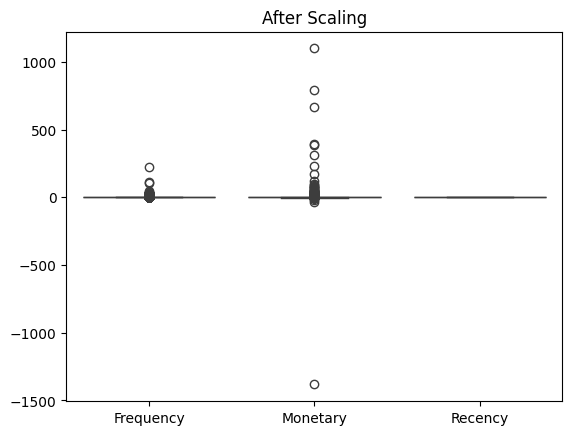

In [8]:
numeric_only_df = grouped_customer_df[["Frequency", "Monetary", "Recency"]]

# After scaling
sns.boxplot(data=numeric_only_df)
plt.title("After Scaling")
plt.show()

In [9]:
# K-Means Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(numeric_only_df)

grouped_customer_df["ClusterLabel"] = kmeans.labels_

print("K-Means Clustering Results:")
print(tabulate(grouped_customer_df.head(), headers="keys", tablefmt="grid"))

print("\nK-Means Clustering With Vlaue of 2:")
print(
    tabulate(
        grouped_customer_df[grouped_customer_df["ClusterLabel"] == 2 ],
        headers="keys",
        tablefmt="grid",
    )
)

print("\nCluster Distribution:")
print(grouped_customer_df["ClusterLabel"].value_counts())

K-Means Clustering Results:
+----+-----------------+-------------+------------+------------+----------------+
|    | CustomerId      |   Frequency |   Monetary |    Recency |   ClusterLabel |
+====+=================+=============+============+============+================+
|  0 | CustomerId_1    |  -0.333333  |  -0.395307 |  1.22917   |              0 |
+----+-----------------+-------------+------------+------------+----------------+
|  1 | CustomerId_10   |  -0.333333  |  -0.395307 |  1.22917   |              0 |
+----+-----------------+-------------+------------+------------+----------------+
|  2 | CustomerId_1001 |  -0.111111  |   0        |  1.35417   |              0 |
+----+-----------------+-------------+------------+------------+----------------+
|  3 | CustomerId_1002 |   0.222222  |  -0.207866 |  0.0208333 |              0 |
+----+-----------------+-------------+------------+------------+----------------+
|  4 | CustomerId_1003 |  -0.0555556 |   0        | -0.270833  |      

#### Results

The K-Means Clustering has grouped the RFM data into 3 clusters. As shown above, values assigned 0 are customers with least frequenct, monetary and recency values. These group of customers will be identified as high risk.

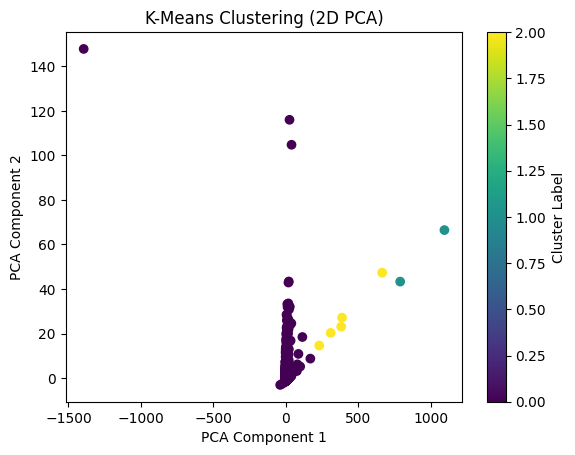

In [10]:
# Reduce the data to 2D using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(numeric_only_df)

# Plot the clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap="viridis")
plt.title("K-Means Clustering (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

In [11]:
print("Assign the High-Risk Label")

grouped_customer_df["is_high_risk"] = np.where(grouped_customer_df["ClusterLabel"] == 0, 1, 0)

print("\nAfter Assigning Is High Risk Label:")
print(tabulate(grouped_customer_df.head(), headers="keys", tablefmt="grid"))

print("\nHigh Risk Distribution:")
print(grouped_customer_df["is_high_risk"].value_counts())

Assign the High-Risk Label

After Assigning Is High Risk Label:
+----+-----------------+-------------+------------+------------+----------------+----------------+
|    | CustomerId      |   Frequency |   Monetary |    Recency |   ClusterLabel |   is_high_risk |
+====+=================+=============+============+============+================+================+
|  0 | CustomerId_1    |  -0.333333  |  -0.395307 |  1.22917   |              0 |              1 |
+----+-----------------+-------------+------------+------------+----------------+----------------+
|  1 | CustomerId_10   |  -0.333333  |  -0.395307 |  1.22917   |              0 |              1 |
+----+-----------------+-------------+------------+------------+----------------+----------------+
|  2 | CustomerId_1001 |  -0.111111  |   0        |  1.35417   |              0 |              1 |
+----+-----------------+-------------+------------+------------+----------------+----------------+
|  3 | CustomerId_1002 |   0.222222  |  -0.20

In [23]:
print("Integrate the Target Variable:")

processed_df = dm.load_csv(load_clean=True, file_name=PROCESSED_FEATURES_DATA_FILE_NAME)

merged_df = pd.merge(processed_df, grouped_customer_df, on=Columns.CustomerId.value, how="outer")
merged_df.drop(columns=["Unnamed: 0"], inplace=True)

Integrate the Target Variable:
Loading ../data/processed/processed_features.csv...
Sucessfully loaded ../data/processed/processed_features.csv!


In [24]:
print("\nFinal Merged Data:")
print(tabulate(merged_df.head(), headers="keys", tablefmt="grid"))


Final Merged Data:
+----+--------------------------+----------------------------+------------------------+--------------------+--------------------+-----------------+--------------------------+----------------------------+------------------------------+-----------------------------+------------------------------+---------------------+-------------+------------+------------+----------------+----------------+
|    |   TotalTransactionAmount |   AverageTransactionAmount |   TransactionAmountSTD |   TransactionCount |   ActiveYearsCount | CustomerId      |   AverageTransactionHour |   MostCommonTransactionDay |   MostCommonTransactionMonth | MostCommonProductCategory   |   UniqueProductCategoryCount | MostCommonChannel   |   Frequency |   Monetary |    Recency |   ClusterLabel |   is_high_risk |
+====+==========================+============================+========================+====================+====================+=================+==========================+======================

In [25]:
print("Save high risk categorization + processed features")

dm.save_to_csv(df=merged_df, file_name=PROCESSED_FEATURES_DATA_FILE_NAME)

Save high risk categorization + processed features
Sucessfully saved dataframe to ../data/processed/processed_features.csv!
